In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
api = wandb.Api()

In [3]:
runs = api.runs(path="seas/vmcts")

In [4]:
df = pd.DataFrame()

groups = ["exploration-sweep-5"] # ["exploration-sweep-3", "exploration-sweep-4"]

for run in runs:
    if run.group in groups:
        history = run.summary
        # history = run.history(samples=1000, 
        keys=[
                            "final/pass_at_5000",
                            "final/pass_at_2000",
                            "final/pass_at_1000",
                            "final/pass_at_500",
                            "final/n_tokens",
                            "final/width",
                            "final/depth",
                            "final/total_nodes",
                            "final/max_value",
                            "final/min_value",
                            ]
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["model_arg_temp"] = run.config["model_arg_temp"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]
        # for key in history.keys():
        #     run_dict[key] = list(history[key])[-1]

        run_df = pd.DataFrame(run_dict, index=[0])
        df = pd.concat([df, run_df])

In [5]:
df.head()

,id,group,discovery_factor,widen_policy_value,seed,model_arg_temp,final/pass_at_5000,final/pass_at_2000,final/pass_at_1000,final/pass_at_500,final/n_tokens,final/width,final/depth,final/total_nodes,final/max_value,final/min_value
0,a637tcs3,exploration-sweep-5,30.0,0.1,29,1.0,1,0,0,0,2848,5,16,58,10,-110
0,qc7w5po9,exploration-sweep-5,3.0,0.05,29,1.0,1,0,0,0,2382,4,13,38,7,-25
0,qbi9w4rz,exploration-sweep-5,10.0,0.2,29,1.0,1,0,0,0,2309,6,19,64,7,-42
0,vta8skg7,exploration-sweep-5,3.0,0.1,26,1.0,1,1,0,0,1407,2,17,32,6,-6
0,acpke1lu,exploration-sweep-5,1.0,0.1,26,1.0,1,1,1,0,1000,4,17,36,10,-3


In [6]:
len(df)

1354

In [7]:
df["discovery_factor"].unique()

array(['30.0', '3.0', '10.0', '1.0'], dtype=object)

In [22]:
# Save data for best configuration
discovery_factor = '3.0'
widen_policy_value = '0.1'
config_df = df[(df["discovery_factor"] == discovery_factor) & (df["widen_policy_value"] == widen_policy_value)]
config_df.to_csv("best_vmcts_evalopt0.csv")

In [8]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

In [9]:
def compute_pass_at_t_and_ci(df, t):
    passes = (df[f"final/n_tokens"] <= t).sum()
    total = len(df)
    pass_at_t = passes / total
    low, high = confidence_interval(passes, total)
    return pass_at_t, low, high

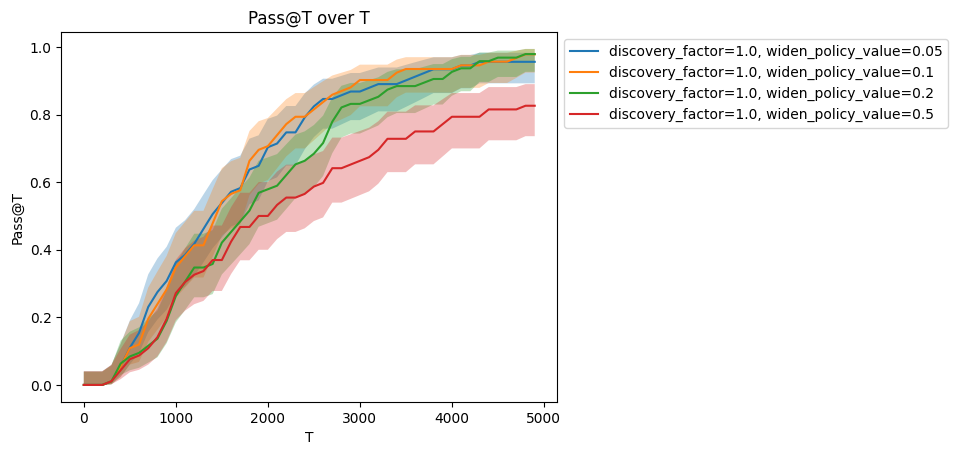

In [10]:
ts = np.arange(0, 5000, 100)

for discovery_factor in ['1.0']: # sorted(df["discovery_factor"].unique()):
    for widen_policy_value in sorted(df["widen_policy_value"].unique()):
        config_df = df[(df["discovery_factor"] == discovery_factor) & (df["widen_policy_value"] == widen_policy_value)]
        
        success_rates, lows, highs = [], [], []
        for t in ts:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df, t)
            success_rates.append(success_rate)
            lows.append(low)
            highs.append(high)

        plt.plot(ts, success_rates, label=f"discovery_factor={discovery_factor}, widen_policy_value={widen_policy_value}")
        plt.fill_between(ts, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("T")
plt.ylabel("Pass@T")
plt.title("Pass@T over T")
plt.show()

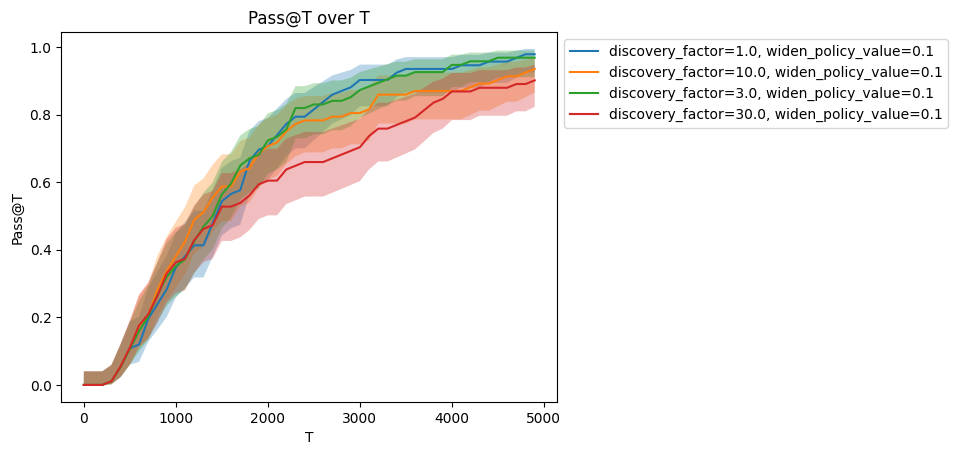

In [12]:
ts = np.arange(0, 5000, 100)

for discovery_factor in sorted(df["discovery_factor"].unique()):
    for widen_policy_value in ['0.1']:  #sorted(df["widen_policy_value"].unique()):
        config_df = df[(df["discovery_factor"] == discovery_factor) & (df["widen_policy_value"] == widen_policy_value)]
        
        success_rates, lows, highs = [], [], []
        for t in ts:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df, t)
            success_rates.append(success_rate)
            lows.append(low)
            highs.append(high)

        plt.plot(ts, success_rates, label=f"discovery_factor={discovery_factor}, widen_policy_value={widen_policy_value}")
        plt.fill_between(ts, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("T")
plt.ylabel("Pass@T")
plt.title("Pass@T over T")
plt.show()

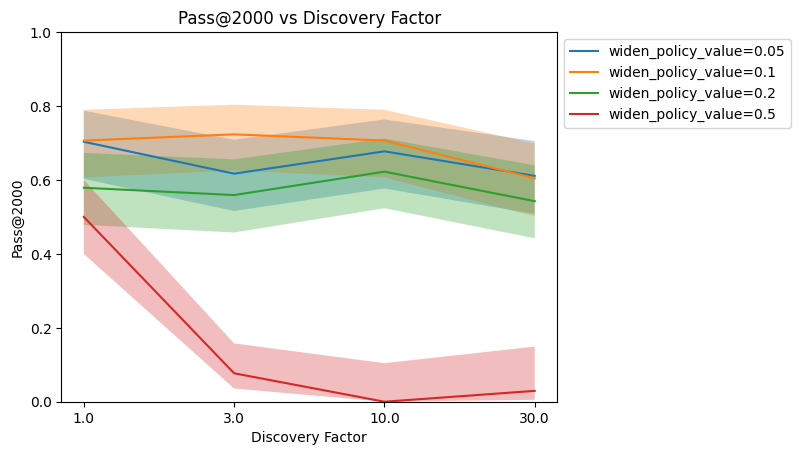

In [18]:
# Pass @T vs discovery factor for different widen_policy_value

T = 2000

discovery_factors = [str(f) for f in sorted([float(s) for s in df["discovery_factor"].unique()])]
widen_policy_values = sorted(df["widen_policy_value"].unique())

for widen_policy_value in widen_policy_values:
    config_df = df[df["widen_policy_value"] == widen_policy_value]
    success_rates, lows, highs = [], [], []
    for discovery_factor in discovery_factors:
        config_df_2 = config_df[config_df["discovery_factor"] == discovery_factor]
        if config_df_2.empty:
            success_rate, low, high = np.nan, np.nan, np.nan
        else:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(discovery_factors, success_rates, label=f"widen_policy_value={widen_policy_value}")
    plt.fill_between(discovery_factors, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Discovery Factor")
plt.ylabel(f"Pass@{T}")
plt.ylim(0,1)
plt.title(f"Pass@{T} vs Discovery Factor")
plt.show()

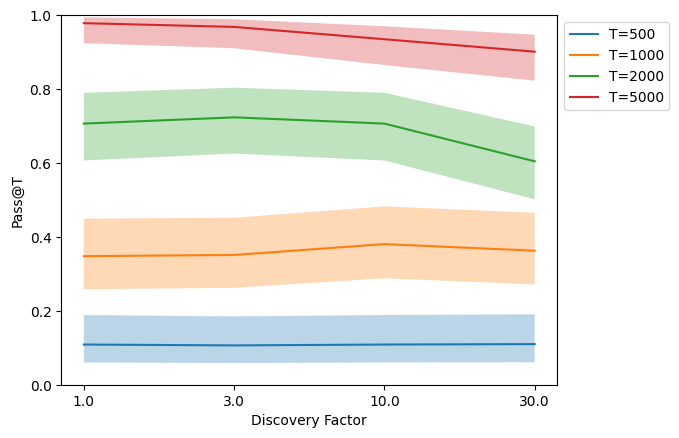

In [19]:
# Pass @T vs discovery factor for different widen_policy_value

discovery_factors = [str(f) for f in sorted([float(s) for s in df["discovery_factor"].unique()])]
widen_policy_values = sorted(df["widen_policy_value"].unique())

for T in [500, 1000, 2000, 5000]:
    for widen_policy_value in ["0.1"]: # widen_policy_values:
        config_df = df[df["widen_policy_value"] == widen_policy_value]
        success_rates, lows, highs = [], [], []
        for discovery_factor in discovery_factors:
            config_df_2 = config_df[config_df["discovery_factor"] == discovery_factor]
            if config_df_2.empty:
                success_rate, low, high = np.nan, np.nan, np.nan
            else:
                success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
            success_rates.append(success_rate)
            lows.append(low)
            highs.append(high)

        plt.plot(discovery_factors, success_rates, label=f"T={T}")
        plt.fill_between(discovery_factors, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Discovery Factor")
plt.ylabel(f"Pass@T")
plt.ylim(0,1)
plt.show()

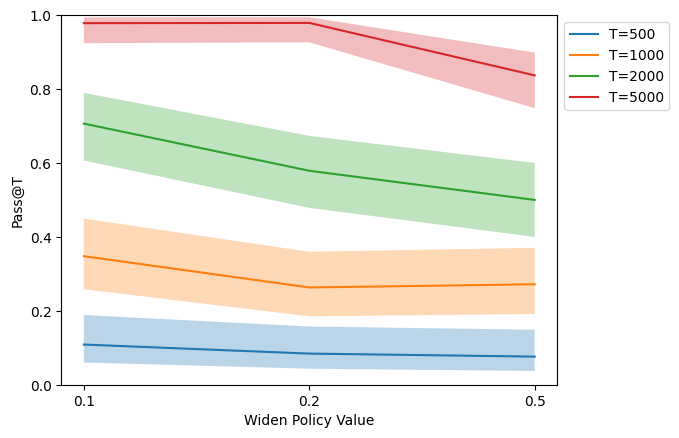

In [20]:
discovery_factors = sorted(df["discovery_factor"].unique())
widen_policy_values = sorted(df["widen_policy_value"].unique())[1:]

for T in [500, 1000, 2000, 5000]:
    for discovery_factor in ["1.0"]: # discovery_factors:
        config_df = df[df["discovery_factor"] == discovery_factor]
        success_rates, lows, highs = [], [], []
        for widen_policy_value in widen_policy_values:
            config_df_2 = config_df[config_df["widen_policy_value"] == widen_policy_value]
            if config_df_2.empty:
                success_rate, low, high = np.nan, np.nan, np.nan
            else:
                success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
            success_rates.append(success_rate)
            lows.append(low)
            highs.append(high)

        plt.plot(widen_policy_values, success_rates, label=f"T={T}")
        plt.fill_between(widen_policy_values, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Widen Policy Value")
plt.ylabel(f"Pass@T")
plt.ylim(0,1)
plt.show()


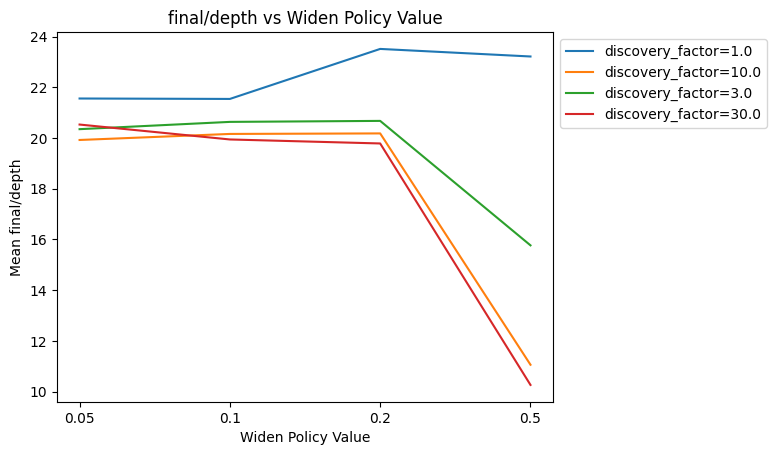

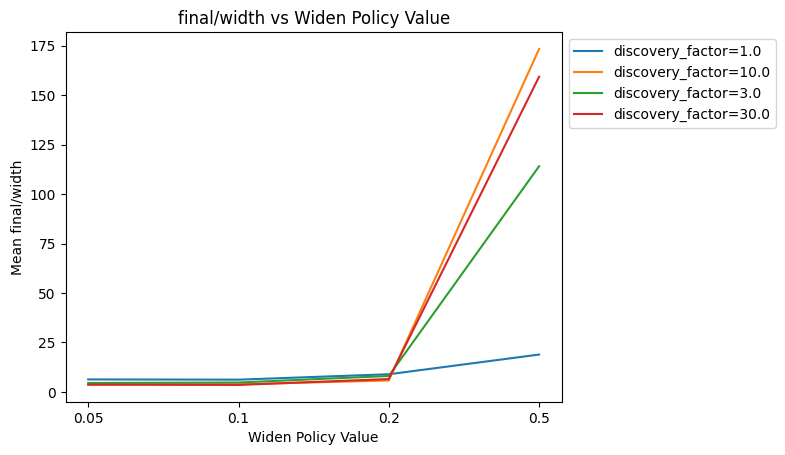

In [21]:
# depth and width vs widen_policy_value for different discovery_factor

for key in ["final/depth", "final/width"]:

    discovery_factors = sorted(df["discovery_factor"].unique())
    widen_policy_values = sorted(df["widen_policy_value"].unique())

    for discovery_factor in discovery_factors:
        config_df = df[df["discovery_factor"] == discovery_factor]
        mean, std = [], []
        for widen_policy_value in widen_policy_values:
            config_df_2 = config_df[config_df["widen_policy_value"] == widen_policy_value]
            mean.append(config_df_2[key].mean())
            std.append(config_df_2[key].std())

        plt.plot(widen_policy_values, mean, label=f"discovery_factor={discovery_factor}")

    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.xlabel("Widen Policy Value")
    plt.ylabel(f"Mean {key}")
    plt.title(f"{key} vs Widen Policy Value")
    plt.show()